In [3]:
import spacy
from spacy import displacy
import json
from datetime import datetime
from spacy.tokens import DocBin, Doc, Span
from tqdm import tqdm
from spacy.util import filter_spans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import defaultdict
from spacy.training.example import Example

In [39]:
with open(r"train.json", 'r') as f:
    data = json.load(f)

In [40]:
unique_ids = list(set([i['id'] for i in data]))

In [41]:
gt = []

In [42]:
for id in unique_ids:
    temp = []
    for i in data:
        if i['id'] == id:
            temp.append(i)
    temp_gt = temp[0]
    for i in temp:
        date = datetime.fromisoformat(i['updated_at'].strip('Z'))
        if date > datetime.fromisoformat(temp_gt['updated_at'].strip('Z')):
            temp_gt = i
    gt.append(temp_gt)

In [43]:
training_data = []
for example in gt:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for annotation in example['label']:
        start = annotation['start']
        end = annotation['end']
        label = annotation['labels'][0]
        temp_dict['entities'].append((start, end, label))
    training_data.append(temp_dict)


In [9]:
def max_200(training_data):
    new_data = []
    for example in training_data:
        example_text = example['text']
        example_entities = example['entities']

        new_text = ' '.join(example_text.split()[:min([200, len(example_text.split())])])
        new_entities = [i for i in example_entities if i[1] <= len(new_text)]

        new_entrie = {'text':new_text, 'entities':new_entities}

        new_data.append(new_entrie)
    
    return new_data

In [10]:
#training_data = max_200(training_data)

In [44]:
validation_data = training_data[int(len(training_data)*0.8):]
training_data = training_data[:int(len(training_data)*0.8)]

In [12]:
nlp = spacy.blank("en")
doc_bin = DocBin()

In [13]:
for training_example in tqdm(training_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("train.spacy")

100%|██████████| 24/24 [00:00<00:00, 82.42it/s]

Skipping entity


In [14]:
for training_example in tqdm(validation_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("val.spacy")

100%|██████████| 6/6 [00:00<00:00, 84.42it/s]


In [15]:
!python -m spacy init fill-config base_config.cfg config.cfg

^C


✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./val.spacy

ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    128.13    0.00    0.00    0.00    0.00
  8     200       2974.89   9157.86   45.74   75.86   32.74    0.46
 16     400       5188.47   6878.54   44.27   45.45   43.15    0.44
 25     600       1848.79   3731.40   67.30   71.33   63.69    0.67
 33     800       2927.29   3308.28   74.12   80.00   69.05    0.74
 41    1000        676.73   1245.55   82.91   88.51   77.98    0.83
 50    1200        300.32    512.95   82.42   83.95   80.95    0.82
 58    1400        198.68    350.74   85.21   91.47   79.76    0.85
 66    1600        144.58    267.74 

c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\Bilal\.conda\envs\textMining\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [16]:
nlp_ner = spacy.load("model-best")

In [17]:
with open(r"test.json", 'r') as f:
    data_test = json.load(f)

In [18]:
unique_ids_test = list(set([i['id'] for i in data_test]))

In [19]:
gt_test = []

In [20]:
for id in unique_ids_test:
    temp = []
    for i in data_test:
        if i['id'] == id:
            temp.append(i)
    temp_gt = temp[0]
    for i in temp:
        date = datetime.fromisoformat(i['updated_at'].strip('Z'))
        if date > datetime.fromisoformat(temp_gt['updated_at'].strip('Z')):
            temp_gt = i
    gt_test.append(temp_gt)

In [21]:
test_data = []
for example in gt_test:
    temp_dict = {}
    temp_dict['text'] = example['text']
    temp_dict['entities'] = []
    for annotation in example['label']:
        start = annotation['start']
        end = annotation['end']
        label = annotation['labels'][0]
        temp_dict['entities'].append((start, end, label))
    test_data.append(temp_dict)

In [22]:
#test_data = max_200(test_data)

In [45]:
predictions_test = []

In [46]:
for example in test_data:
    doc = nlp_ner(example['text'])
    ner_results = {'text': example['text'], 'entities': []}
    for ent in doc.ents:
        ner_results['entities'].append((ent.start_char, 
                                        ent.end_char,
                                        ent.label_))
    predictions_test.append(ner_results)


In [47]:
predictions_train = []

In [48]:
for example in training_data:
    doc = nlp_ner(example['text'])
    ner_results = {'text': example['text'], 'entities': []}
    for ent in doc.ents:
        ner_results['entities'].append((ent.start_char, 
                                        ent.end_char,
                                        ent.label_))
    predictions_train.append(ner_results)

In [49]:
predictions_val = []

In [50]:
for example in validation_data:
    doc = nlp_ner(example['text'])
    ner_results = {'text': example['text'], 'entities': []}
    for ent in doc.ents:
        ner_results['entities'].append((ent.start_char, 
                                        ent.end_char,
                                        ent.label_))
    predictions_val.append(ner_results)

In [25]:
def confusion_matrix_ner(labels:list, true:list, pred:list) -> np.ndarray:
    
    def extend_bounds(indices:tuple) -> list:
        
        extension = []
        modifications = [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (1,1), (-1,1), (1,-1), (0,0)]
        
        for mod in modifications:
            extension.append((indices[0]+mod[0], indices[1]+mod[1]))
        return extension

    cm = np.zeros((len(labels) + 1, len(labels) + 1))
    
    used_idx = []

    for (true_instance, pred_instance) in zip(true, pred):

        true_indices = [x[:2] for x in true_instance['entities']]
        pred_indices = [x[:2] for x in pred_instance['entities']]
        
        true_labels = [x[2] for x in true_instance['entities']]
        pred_labels = [x[2] for x in pred_instance['entities']]
 
        for i, idx_true in enumerate(true_indices):

            for j, idx_pred in enumerate(pred_indices):

                if idx_true in extend_bounds(idx_pred):
                    
                    if true_labels[i] == pred_labels[j]:
                        cm[labels.index(true_labels[i])][labels.index(true_labels[i])] += 1
                        used_idx.append(j)
                        break

                    else:
                        cm[labels.index(true_labels[i])][labels.index(pred_labels[j])] += 1
                        used_idx.append(j)
                        break

                elif j == len(pred_indices) - 1:
                    cm[labels.index(true_labels[i])][-1] += 1
                
                else:
                    continue

    for i, pred_instance in enumerate(pred):
        if i not in used_idx:
            for pred_label in pred_instance['entities']:
                cm[-1][labels.index(pred_label[2])] += 1
        
    return cm

In [26]:
labels = ['DATE', 'TIME', 'LOCATION', 'EMPLOYEE', 'UNEXPECTED EVENT', 'CAUSE', 'ACTIVITY', 'SOLUTION', 'EXPECTED EVENT']

In [54]:
cm_test = confusion_matrix_ner(labels, test_data, predictions_test)
cm_train = confusion_matrix_ner(labels, training_data, predictions_train)
cm_val = confusion_matrix_ner(labels, validation_data, predictions_val)

In [34]:
def calculate_metrics(confusion_matrix):
    """
    Calculate precision, recall, and F1 score based on a confusion matrix.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.

    Returns:
    - precision (float): Precision score.
    - recall (float): Recall score.
    - f1_score (float): F1 score.
    """

    # Extracting true positives, false positives, false negatives
    tp = np.diag(confusion_matrix)
    fp = np.sum(confusion_matrix, axis=0) - tp
    fn = np.sum(confusion_matrix, axis=1) - tp

    # Handling division by zero
    precision = np.sum(tp / np.maximum(tp + fp, 1e-9)) / len(tp)
    recall = np.sum(tp / np.maximum(tp + fn, 1e-9)) / len(tp)

    # Handling cases where precision and recall are both zero
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

In [55]:
print(calculate_metrics(cm_test))
print(calculate_metrics(cm_train))
print(calculate_metrics(cm_val))

(0.6, 0.30590909090909085, 0.40521826392373306)
(0.7197717996289426, 0.8458192645758569, 0.7777214218245624)
(0.552797619047619, 0.3382988721804511, 0.4197318986412304)


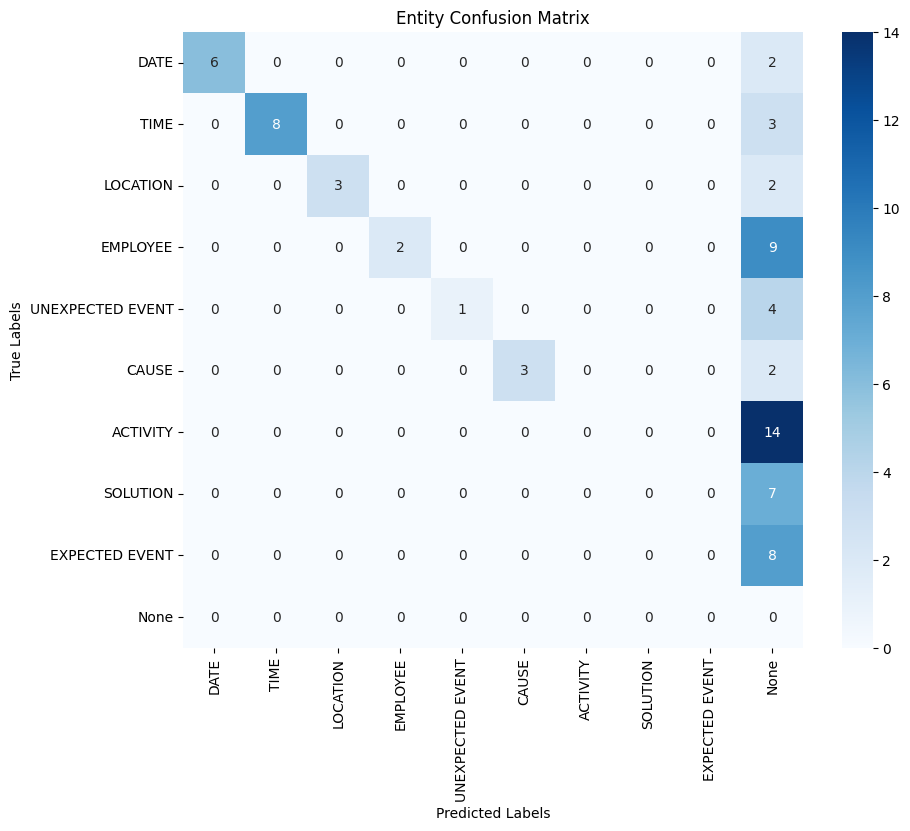

In [36]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels+['None'], yticklabels=labels+['None'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Entity Confusion Matrix")
plt.show()

In [ ]:
with open('predictions.json', 'w') as outp:
    json.dump(predictions, outp)

In [113]:
doc = nlp_ner(test_data[2]['text'])
spacy.displacy.render(doc, style='ent', jupyter=True)

In [109]:
with open('predictions.json', 'w') as outp:
    json.dump(predictions, outp)